In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import subprocess
import os
from os import path
from datetime import datetime

### Same prompt

In [175]:
# Prompt user for manual or automated argument
while (True):
    dataset_type = str(input("Please enter 'manual', 'automated', or 'both' for the type of data set you are processing: "))
    # make case insenstive
    dataset_type = dataset_type.lower()
    if (dataset_type == "manual" or dataset_type == "automated" or dataset_type == 'both'):
        break
    print("Invalid argument")

Please enter 'manual', 'automated', or 'both' for the type of data set you are processing: automated


In [331]:
# Prompt user for type of analsyis
while (True):
    options = ["Bacillariophyceae", "Dinoflagellata", "Haptophyta",
               "other than diatoms dinoflagellates or haptophytes", "All", "All but other"]
    # Print out options
    for i in range(len(options)):
        print(str(i+1) + ":", options[i])
    analysis_type = int(input("Please enter a number (1-6) for the type analysis: "))
    if (analysis_type in range(1,7)):
        analysis_type = str(options[analysis_type-1])
        break
    print("Invalid argument")

1: Bacillariophyceae
2: Dinoflagellata
3: Haptophyta
4: other than diatoms dinoflagellates or haptophytes
5: All
6: All but other
Please enter a number (1-6) for the type analysis: 1


In [332]:
# # Ask user if running analysis on a new cruise
# while (True):
#     reply = str(input('Are you running the analysis on a new cruise? (y/n): ')).lower().strip()
#     if reply[0] == 'y':
#         break
#     if reply[0] == 'n':
#         break
#     else:
#         print("Please enter y/n")

In [333]:
# # first call bash script to get necessary file inputs
# # for geographic script, choose query_samples for underway gps data alignment as input script
# # for worms script, choose names_ids.csv for input script
# # only call if files don't exist or calling on new cruise data so program doesn't need to take full time to run
# if ( not reply[0] != 'y'):
#     subprocess.call(['./exec.sh', reply[0]])

In [334]:
# read different columns based on dataset type
if (dataset_type == 'manual'):
    columns = ['associatedMedia', 'data_provider_category_HumanObservation', 
               'higherClassification_group', 'scientificName_HumanObservation',
               'Biovolume', 'maxFeretDiameter']
elif (dataset_type == 'automated'):
    columns = ['associatedMedia', 'data_provider_category_MachineObservation', 'maxFeretDiameter',
              'minFeretDiameter', 'Area', 'Biovolume']
else:
    columns = ['associatedMedia', 'data_provider_category_HumanObservation', 
               'data_provider_category_MachineObservation', 'higherClassification_group', 
               'scientificName_HumanObservation','Biovolume', 'maxFeretDiameter']

### Matching code

In [335]:
# read in level 1_b file
sample_subset = pd.read_csv('../auto_join/level_1b.csv', usecols=columns)

In [336]:
## prompt user to ask for above/below the threshold
while (True):
    options = ['Max threshold: <', 'Min threshold: >']
    for i in range(len(options)):
        print(str(i+1) + ":", options[i])
    sign = int(input("Please enter a number (1 or 2) to choose comparison operator: "))
    if (sign in range(1,3)):
        break
    print("Invalid argument")
print('\n')

## prompt user to ask for which size parameter to analyze
while (True):
    options = ['maxFeretDiameter', 'minFeretDiameter', 'Area', 'Biovolume']
    # Print out options
    for i in range(len(options)):
        print(str(i+1) + ":", options[i])
    param = int(input("Please enter a number (1-4) for the type analysis: "))
    if (param in range(1,5)):
        param = str(options[param-1])
        break
    print("Invalid argument")
print('\n')

## prompt user to ask for desired size distribution, keep at 20 for now
threshold = float(input('Enter threshold value to analyze (micrometers): '))

1: Max threshold: <
2: Min threshold: >
Please enter a number (1 or 2) to choose comparison operator: 1


1: maxFeretDiameter
2: minFeretDiameter
3: Area
4: Biovolume
Please enter a number (1-4) for the type analysis: 2


Enter threshold value to analyze (micrometers): 20


### Matching code for the next 5 cells

In [337]:
# get higher order data based on dataset
if (dataset_type == 'automated'):
    auto_taxon_info = pd.read_csv('../auto_join/resolved_auto.csv', 
                                  usecols=['name', 'resolved_names', 'resolved_higher_order_fromgnr', 'alt_datasource'])
    # merge to get taxa data
    sample_subset = pd.merge(sample_subset, auto_taxon_info, how='left', left_on='data_provider_category_MachineObservation', right_on='name')
    # rename resolved_higher_order column to match
    sample_subset.rename(columns={'resolved_higher_order_fromgnr':'higherClassification_group_automated'}, inplace=True)
elif (dataset_type == 'manual'):
    man_taxon_info = pd.read_csv('../auto_join/resolved_manual_matched_matchIDs_LOOKUPsorted.csv', 
                                  usecols=['name', 'resolved_names', 'alt_datasource'])
    # merge to get taxa data
    sample_subset = pd.merge(sample_subset, man_taxon_info, how='left', left_on='data_provider_category_HumanObservation', right_on='name')
    sample_subset.rename(columns={'higherClassification_group':'higherClassification_group_manual'}, inplace=True)
else:
    auto_taxon_info = pd.read_csv('../auto_join/resolved_auto.csv', 
                                  usecols=['name', 'resolved_names', 'resolved_higher_order_fromgnr', 'alt_datasource'])
    # merge to get taxa data
    sample_subset = pd.merge(sample_subset, auto_taxon_info, how='left', left_on='data_provider_category_MachineObservation', right_on='name')
    # rename resolved_higher_order column to match
    sample_subset.rename(columns={'resolved_higher_order_fromgnr':'higherClassification_group_automated', 
                           'higherClassification_group':'higherClassification_group_manual'}, 
                   inplace=True)
    man_taxon_info = pd.read_csv('../auto_join/resolved_manual_matched_matchIDs_LOOKUPsorted.csv', 
                                  usecols=['name', 'resolved_names'])
    # merge to get taxa data
    sample_subset = pd.concat([sample_subset, man_taxon_info], axis=1, sort=False)

In [338]:
# separate out roi id from associatedMedia
sample_subset['roi'] = sample_subset['associatedMedia']
sample_subset.roi = sample_subset.roi.str.slice(68, 74)
# gets rid of leading zeros
sample_subset.roi = sample_subset.roi.str.lstrip("0")
# cut associatedMedia to just be associatedMedia of sample
sample_subset.associatedMedia = sample_subset.associatedMedia.str.slice(0, 67)

In [339]:
# read in gps coordinates file
coords = pd.read_csv('geographic_subset.csv', usecols=['date','pid', 'gps_furuno_latitude', 
                                                       'gps_furuno_longitude'])
# merge with sample_subset based on smaple ids
sample_subset = pd.merge(sample_subset, coords, how='left', left_on='associatedMedia', right_on='pid')
# get unique coordinates
unique_coords = sample_subset.groupby(['gps_furuno_latitude', 'gps_furuno_longitude', 'date']).size().reset_index().rename(columns={0:'count'})

In [340]:
# read in volume data
volumes = pd.read_csv("../volume/volumes.csv")
# merge with samples
volumes.rename(columns={'permalink': 'associatedMedia'}, inplace=True)
sample_subset = pd.merge(sample_subset, volumes, how='left', on='associatedMedia')

In [341]:
# first exclude abiotic particles
sample_subset = sample_subset[sample_subset['alt_datasource'] != "OCB"]
# calculate total biovolume per sample
total = sample_subset.groupby('associatedMedia')['Biovolume'].sum().reset_index()
total.rename(columns={'Biovolume':'total_biovolume'}, inplace=True)
# merge 2 data frames based on sample_identifier
sample_subset = pd.merge(sample_subset, total, how='left', on='associatedMedia')

In [342]:
# include NotApplicable categories as other
if (dataset_type == 'manual'):
    sample_subset.higherClassification_group_manual[sample_subset['higherClassification_group_manual'] == 'NotApplicable'] = 'other than diatoms dinoflagellates or haptophytes'
elif (dataset_type == 'automated'):
    sample_subset.higherClassification_group_automated[sample_subset['higherClassification_group_automated'] == 'NotApplicable'] = 'other than diatoms dinoflagellates or haptophytes'
else:
    sample_subset.loc[sample_subset['higherClassification_group_manual'] == 'NotApplicable', 
                ['higherClassification_group_manual', 'higherClassification_group_automated']] = 'other than diatoms dinoflagellates or haptophytes'

/Users/Kathy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [343]:
# add variable for above or below threshold
# add variable for choices of other size parameters (4 total)
# filter out rows below threshold
if (sign == 1):
    sample_subset = sample_subset[sample_subset[param] < threshold]
else:
    sample_subset = sample_subset[sample_subset[param] > threshold]

In [344]:
# group by sample identifiers and higher ranks to calculate total biovolume per ranking
if (dataset_type == 'both'):
    # need 2 data frames for both
    auto_samples = sample_subset.groupby(
        ['associatedMedia', 'higherClassification_group_automated'.format(dataset_type)]).agg(
        {
            'Biovolume': 'sum',
            'gps_furuno_latitude': 'first',
            'total_biovolume': 'first',
            'volume_imaged': 'first'
        }
    ).reset_index()
    # calculate percent biovolume
    auto_samples['percent_biovolume'] = auto_samples['Biovolume']/auto_samples['total_biovolume']

    # manual data frame
    manual_samples = sample_subset.groupby(
        ['associatedMedia', 'higherClassification_group_manual'.format(dataset_type)]).agg(
        {
            'Biovolume': 'sum',
            'gps_furuno_latitude': 'first',
            'total_biovolume': 'first',
            'volume_imaged': 'first'
        }
    ).reset_index()
    # calculate percent biovolume
    manual_samples['percent_biovolume'] = manual_samples['Biovolume']/manual_samples['total_biovolume']
else:
    sample_subset = sample_subset.groupby(
        ['associatedMedia', 'higherClassification_group_{}'.format(dataset_type)]).agg(
        {
            'Biovolume': 'sum',
            'gps_furuno_latitude': 'first',
            'total_biovolume': 'first',
            'date': 'first',
            'volume_imaged': 'first'
        }
    ).reset_index()
    # calculate percent biovolume
    sample_subset['percent_biovolume'] = sample_subset['Biovolume']/sample_subset['total_biovolume']

In [345]:
# calculate concentration from abundance and volume
if (dataset_type == 'both'):
    # calculate concentration for automated classifications
    auto_samples['concentration'] = auto_samples.Biovolume/auto_samples.volume_imaged
    # convert to float
    auto_samples.concentration = auto_samples.concentration.astype(float)
    # calculate concentrations for manual classifications
    manual_samples['concentration'] = manual_samples.Biovolume/manual_samples.volume_imaged
    # convert to float
    manual_samples.concentration = manual_samples.concentration.astype(float)
else:
    sample_subset['concentration'] = sample_subset.Biovolume.astype(float)/sample_subset.volume_imaged.astype(float)
    # convert to float
    sample_subset.concentration = sample_subset.concentration.astype(float)

### Matching code for next 2 cells

In [346]:
# filter out to only read user specified analysis_type
if (dataset_type == 'both'):
    if (analysis_type == "All but other"):
        analysis_type = 'other than diatoms dinoflagellates or haptophytes'
        auto_samples = auto_samples[auto_samples['higherClassification_group_automated'] != analysis_type].reset_index()
        manual_samples = manual_samples[manual_samples['higherClassification_group_manual'] != analysis_type].reset_index()
    elif (analysis_type != 'All'):
        auto_samples = auto_samples[auto_samples['higherClassification_group_automated'] == analysis_type].reset_index()
        manual_samples = manual_samples[manual_samples['higherClassification_group_manual'] == analysis_type].reset_index()
else:
    if (analysis_type == "All but other"):
        analysis_type = 'other than diatoms dinoflagellates or haptophytes'
        sample_subset = sample_subset[sample_subset['higherClassification_group_{}'.format(dataset_type)] != analysis_type].reset_index()
    elif (analysis_type != 'All'):
        sample_subset = sample_subset[sample_subset['higherClassification_group_{}'.format(dataset_type)] == analysis_type].reset_index()

In [347]:
# pad with zeros if doesn't exist
if (dataset_type == 'both'):
    auto_samples = auto_samples.merge(unique_coords, how='right').reset_index()
    auto_samples.higherClassification_group_automated = analysis_type
    auto_samples.concentration[auto_samples.concentration.isna()] = 0
    manual_samples = manual_samples.merge(unique_coords, how='right').reset_index()
    manual_samples.higherClassification_group_manual = analysis_type
    manual_samples.concentration[manual_samples.concentration.isna()] = 0
    # get rid of these guys in manual- FAKE ZEROS
    remove = list(only_auto.gps_furuno_latitude)
    manual_samples = manual_samples[~manual_samples['gps_furuno_latitude'].isin(remove)]
# here for auto/manual only 
else:
    # put stuff here
    sample_subset = sample_subset.merge(unique_coords, how='right')
    sample_subset.higherClassification_group_automated = analysis_type
    sample_subset.percent_biovolume[sample_subset.percent_biovolume.isna()] = 0
    sample_subset.total_biovolume[sample_subset.total_biovolume.isna()] = 0
    sample_subset.concentration[sample_subset.concentration.isna()] = 0
    # reset dates to be datetime objects
    sample_subset['date'] = sample_subset['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:00+00:00'))
    sample_subset = sample_subset.sort_values(by='date',ascending=True).reset_index()

/Users/Kathy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Kathy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Kathy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [304]:
# change to analyis_type string with size parameter string
sample_subset.to_csv(f"autobio_{analysis_type}_{param}_{threshold}.csv")

In [348]:
print("conc min: ", np.min(sample_subset.concentration))
print("conc max: ", np.max(sample_subset.concentration))
print("percent min: ", np.min(sample_subset.percent_biovolume))
print("percent max: ", np.max(sample_subset.percent_biovolume))

conc min:  6690.6679385234465
conc max:  482170.48640327156
percent min:  0.012404763384974302
percent max:  0.4855248785246902


In [328]:
# # take duplicate latitudes and add their concentrations together to make percent biovolume plot
# fig, ax = plt.subplots(figsize=(20, 10))   
# # use unstack()
# if (dataset_type == 'both'): 
#     rois = auto_samples.groupby(['gps_furuno_latitude','higherClassification_group_automated']).sum()['percent_biovolume']
#     rois.unstack().plot(ax=ax, marker='o')
#     rois = manual_samples.groupby(['gps_furuno_latitude','higherClassification_group_manual']).sum()['percent_biovolume']
#     rois.unstack().plot(ax=ax, marker='o')
#     L=plt.legend(title=analysis_type)
#     if (analysis_type != 'All'):
#         L.get_texts()[0].set_text('automated')
#         L.get_texts()[1].set_text('manual')
# else:
#     rois = sample_subset.groupby(['gps_furuno_latitude','higherClassification_group_{}'.format(dataset_type)]).sum()['percent_biovolume']
#     rois.unstack().plot(ax=ax, marker='o')
# # add titles and axes labels
# plt.xlabel('LTER Stations Latitudes', size=20)
# plt.ylabel('% Biovolume in targets with Major Axis Length > {} micrometers '.format(threshold), size=20)
# plt.title('Percent Biovolume along Transect ({} classifications)'.format(dataset_type), size=30)
# ax.tick_params(axis='both', which='major', labelsize=20)
# plt.grid(True)
# # set stations as tick marks
# ax.set_xticks([41.1967, 41.03, 40.8633, 40.6967, 40.5133, 40.3633, 40.2267, 40.1367, 40.0983, 39.94, 39.7733])
# # invert x axis
# ax.invert_xaxis()
# ax.legend(title=None)
# fig1 = plt.gcf()
# plt.show()

No handles with labels found to put in legend.


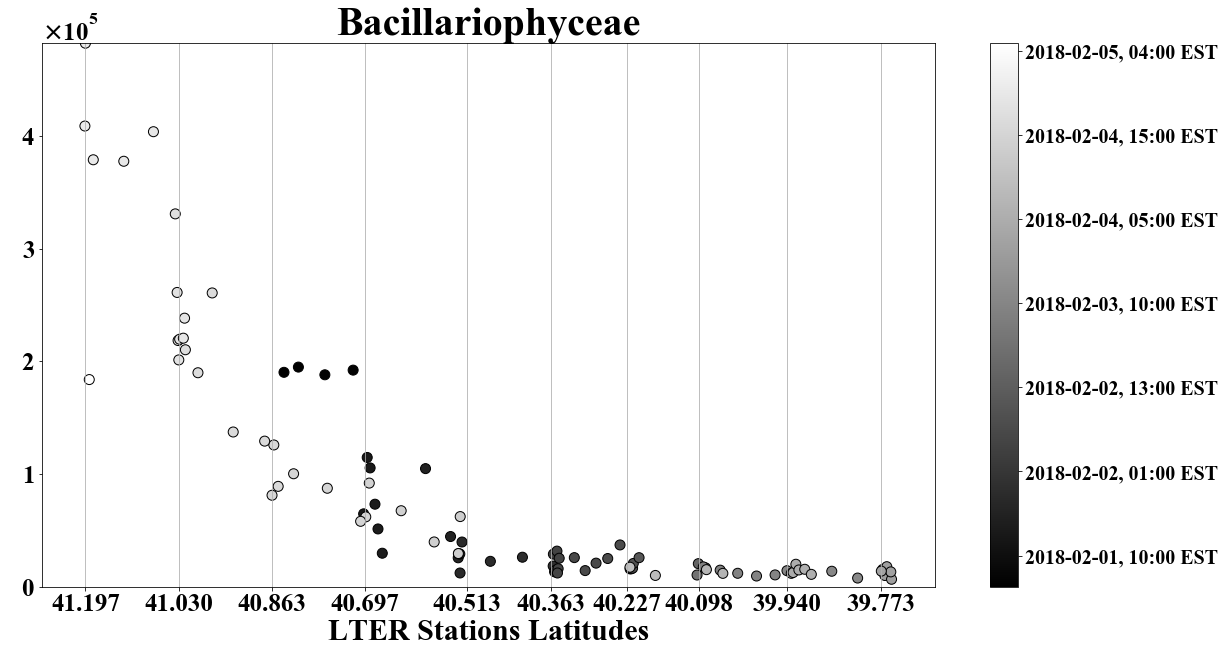

In [349]:
# take duplicate latitudes and add their concentrations together
fig, ax = plt.subplots(figsize=(20, 10))
# use unstack()
if (dataset_type == 'both'): 
    rois = auto_samples.groupby(['gps_furuno_latitude','higherClassification_group_automated']).sum()['concentration']
    rois.unstack().plot(ax=ax, marker='o')
    rois = manual_samples.groupby(['gps_furuno_latitude','higherClassification_group_manual']).sum()['concentration']
    rois.unstack().plot(ax=ax, marker='o')
    L=plt.legend(title=None, prop={"size":20, "family": "Times New Roman"})
    if (analysis_type != 'All'):
        L.get_texts()[0].set_text('automated')
        L.get_texts()[1].set_text('manual')
else:
    rois = sample_subset.groupby(['gps_furuno_latitude','higherClassification_group_{}'.format(dataset_type)]).sum()['concentration']
#     rois.unstack().reset_index().plot.scatter(x='gps_furuno_latitude', y='Bacillariophyceae', 
#                                               ax=ax, marker='o', c=sample_subset.date, 
#                                              cmap='viridis', s=100).grid(axis='x')
    sample_subset.plot.scatter(x='gps_furuno_latitude', y='concentration', 
                          ax=ax, marker='o', c=sample_subset.date, 
                          cmap='gray', edgecolors='black', s=100).grid(axis='x')
    # set color bar
    cb = ax.collections[-1].colorbar
    # stupid stupid color bar, sort indices first
    indices = [sample_subset.date[i] for i in np.linspace(0,sample_subset.shape[0]-1,7).astype(int)]
    cb.ax.set_yticklabels([index.strftime('%Y-%m-%d, %H:00 EST') for index in indices])
    cb.ax.tick_params(labelsize=20)
    # set stupid font
    for l in cb.ax.yaxis.get_ticklabels():
        l.set_family("Times New Roman")
# add titles and axes labels
plt.xlabel('LTER Stations Latitudes', size=30, fontname="Times New Roman")
plt.ylabel(' ')
#plt.ylabel('Biovolume in targets with Max Feret Diameter > {} micrometers'.format(threshold), size = 25, fontname="Times New Roman")
plt.title(analysis_type, size = 40, fontname="Times New Roman")
# set stations as tick marks
# set stations as tick marks
labels=[41.1967, 41.03, 40.8633, 40.6967, 40.5133, 40.3633, 40.2267, 40.0983, 39.94, 39.7733]
ax.set_xticks(labels)
ax.tick_params(axis='both', which='major', labelsize=25)
# set y axis as scientific notation
ax.set_ylim(0, np.max(rois))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(25)
ax.yaxis.get_offset_text().set_fontname("Times New Roman")
ax.yaxis.major.formatter._useMathText=True
# set tick marks font
for tick in ax.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax.get_yticklabels():
    tick.set_fontname("Times New Roman")
# invert x axis
ax.invert_xaxis()
ax.legend(title=None, prop={"size":20, "family": "Times New Roman"})
ax.get_legend().remove()
fig2 = plt.gcf()
plt.show()

In [308]:
# Ask user if want to save graphs
while (True):
    reply = str(input('Save output? (y/n): ')).lower().strip()
    if reply[0] == 'y':
        #fig1.savefig('percent_biovolume.png', bbox_inches='tight')
        fig2.savefig(f'{analysis_type}_biovolume_concentration.png', bbox_inches='tight')
        break
    if reply[0] == 'n':
        break
    else:
        print("Please enter y/n")

Save output? (y/n): y
